# Process all logs

Process all logs in data/full-set, generating plots

In [44]:
%matplotlib inline

###########################
## PROCESS ALL LOG FILES ##
###########################

# helper functions
def getBiasVoltages(iBv):
    # Expecting a byte value e.g. 99 cast as int (153)
    FlMask = 0xF0 # mask for the flame voltage bias i.e. 11110000
    FRshift = 4 # number of right shifts e.g. start with 0x99, end with 0x09
    GMask = 0x0F # mask for the guard voltage bias, no need to shift
    iFbv = (iBv & FlMask) >> FRshift 
    iGbv = iBv & GMask 
    return iFbv, iGbv

def getAlarmGainSpikeCount(iEvent):
    # Byte 6:  EVENT (MSB-LSB: Alarm\Gain\0\Spike\Count\Count\Count\Count) -check
    # Alarm = bit 7
    # Gain = bit 6
    # Spike = bit 4
    # Count = bits 0,1,2,3
    # Notes; count is a sequential 4 bit count, expected to be continuous and
    # carry over o 15, restarting at 0. If any values are found to be missing, action
    # might be required, e.g. linear interpolation to patch missing observations
    AMask = 0x80 # 10000000
    ARshift = 7
    GMask = 0x40 # 01000000
    GRshift = 6
    SMask = 0x10 # 00010000
    SRshift = 4
    CMask = 0x0F # 00001111
    # no shift required for count
    Alarm = (iEvent & AMask) >> ARshift
    Gain = (iEvent & GMask) >> GRshift
    Spike = (iEvent & SMask) >> SRshift
    Count = (iEvent & CMask)
    return Alarm, Gain, Spike, Count

def processLog(filePath, filename):
    # expected return values are
    # FlameA, FlameB, Guard, Flame A&B bias voltage, Alarm (true/false), Gain(true/false)
    # Spike(true/false) and Count(4 bit running count)
    import numpy as np
    # vars
    # expected record length
    iRecLen = 12
    # initialise empty return array
    retarr = np.empty((0,9), dtype='uint8')

    logfilename = filePath + filename
    file = open(logfilename, "r")
    for line in file:
        line = line.rstrip()
        if((len(line) == iRecLen) & (line.find(" ") < 0)):
            # FlameA, FlameB and Guard detector analogue readings
            iFAv = int(line[0:2], 16)
            iFBv = int(line[2:4], 16)
            iG = int(line[4:6], 16)
            iBv = int(line[6:8], 16)
            iFbv, iGbv = getBiasVoltages(iBv)
            iEvent = int(line[10:12], 16)
            Alarm, Gain, Spike, Count = getAlarmGainSpikeCount(iEvent)            
            retarr = np.append(retarr, [[iFAv, iFBv, iG, iFbv, iGbv, Alarm, Gain, Spike, Count]],axis = 0)
    return retarr

def getLogfiles(path, pattern):
    # return a list of files
    import glob
    files = []
    for name in glob.glob(path + pattern):
        files.append(name[len(path):])
    return files

In [57]:
def plotFlamedata(farr):
    # indices
    FAidx = 0
    FBidx = 1
    Gidx = 2
    # x axis time series array
    iIdx = np.arange(1, myarr[:,0].size + 1, 1) # iIdx = np.arange(1, iGlfd.size + 1, 1)
    plt.clf()
    plt.figure(figsize=(18,8))
    plt.plot(iIdx, farr[:,FAidx], label='FlameA')
    plt.plot(iIdx, farr[:,FBidx], label='FlameB')
    plt.plot(iIdx, farr[:,Gidx], label='Guard')
    plt.xlabel('Time(ms)')
    plt.ylabel('AD values')
    plt.title("Flame data")
    plt.legend()
    plt.show()    

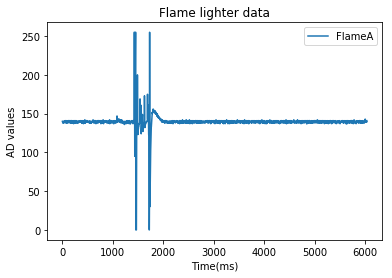

IndexError: too many indices for array

In [59]:
path = "data/full-set/"
pattern = "*.log"
logs = getLogfiles(path, pattern)
for log in logs:
    # print(log)
    # get data arrays
    arr = processLog(path, log)
    plotFlamedata(arr)